In [ ]:
import zipfile
from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file='/content/drive/MyDrive/colab.zip'
z=zipfile.ZipFile(zip_file,'r')
z.extractall()
print (os.listdir())

['.config', 'script.py', 'data_fusion_train.parquet', 'clf_task1', 'tfidf', 'data_fusion_answers_1.csv', 'drive', 'sample_data']


In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers as L
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
import re
import pickle
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train=pd.read_parquet('/content/data_fusion_train.parquet')

In [ ]:
train = train[train.category_id != -1].drop_duplicates('item_name')

In [ ]:
train.head()

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
1,11,6,20:34,"Молоко 3,2%,шт",2.0,8,2,78,None
3,39,4,11:28,"Компот из изюма, 114 ккал",1.0,4,1,71,None
4,39,4,11:28,"Макаронные изделия отварные (масло сливочное),...",1.0,4,1,71,None
17,56,5,11:42,Кофе Капучино Большой Эден 18,1.0,12,1,70,None
40,105,3,01:53,Хлеб на СЫВОРОТКЕ 350г,1.0,7,-1,84,None


In [ ]:
train.shape

(48225, 9)

In [ ]:
train1=train.item_name

In [ ]:
new_train=[]
for i in range (train1.shape[0]):
  new_train.append(train1.iloc[i].lower())

In [ ]:
new_train=pd.DataFrame(new_train,columns=['name'])

In [ ]:
def remove_stop_words (text): #удаление стоп слов
  sentence_list = text.split()
  new_sentence = []
  stop=stopwords.words('russian')
  prod_words=['ккал','шт','г','кг','л','мл','%']
  for word in prod_words:
      stop.append(word)
  
  
  
  for word in sentence_list:
      for stop_word in stop:
          if (stop_word == word):
              word = re.sub(stop_word, '', word)
      new_sentence.append(word) 
  return (" ".join(new_sentence))


In [ ]:
def remove_punctuation(text):  #удаление пунктуации
    #replace every punctuation with a whitespace to keep the words correct
    text = re.sub(r'[^\w\s]',' ',text)
    #remove the successive whitespaces
    _RE_COMBINE_WHITESPACE = re.compile(r"\s+")
    no_punc = _RE_COMBINE_WHITESPACE.sub(" ", text).strip()
    return no_punc

In [ ]:
def remove_numbers(text):
  text = re.sub(r"\d+", "", text, flags=re.UNICODE)
  return text

In [ ]:
def preprocess(df):
  df['name']=df['name'].apply(remove_punctuation)
  df['name']=df['name'].apply(remove_numbers)
  df['name']=df['name'].apply(remove_stop_words)
  return df

In [ ]:
new_train1=preprocess(new_train)

In [ ]:
new_train1

,name
0,молоко
1,компот изюма
2,макаронные изделия отварные масло сливочное
3,кофе капучино большой эден
4,хлеб сыворотке
...,...
48220,напиток энерг ред булл
48221,хеменгуэй дайкири
48222,пиво светлое халзан пл б
48223,экспресс педикюр


In [ ]:
y=train.category_id

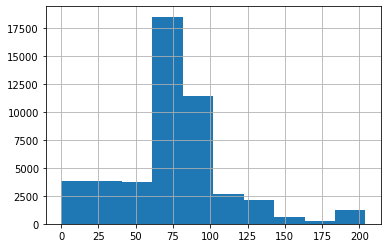

In [ ]:
y.hist()

In [ ]:
def first_word (text):
  first_w=[]
  for i in range (text.shape[0]):
    pattern=re.findall(r'\w*',text.iloc[i])
    first_w.append(pattern[0])
  return pd.DataFrame(first_w,columns=['first word'])

In [ ]:
def last_word (text):
  last_w=[]
  for i in range (text.shape[0]):
    if (text.iloc[i]==''or text.iloc[i]==' '):
      last_w.append(text.iloc[i])
    else:
      pattern=text.iloc[i].split()
      last_w.append(pattern[-1])
  return pd.DataFrame(last_w,columns=['last word'])

In [ ]:
last_w=last_word(new_train1['name'])

In [ ]:
first_w=first_word(new_train1['name'])

In [ ]:
X=np.hstack((new_train1.values,first_w.values,last_w.values))

In [ ]:
X=pd.DataFrame(X,columns=['name','first word','last word'])

In [ ]:
tfidf = CountVectorizer(ngram_range=(3,5), analyzer="char_wb")
X_train_CV1= tfidf.fit_transform(X['name'])
X_train_CV2=tfidf.transform(X['first word'])
X_train_CV3=tfidf.transform(X['last word'])

In [ ]:
from scipy.sparse import hstack
X=hstack((X_train_CV1,X_train_CV2,X_train_CV3))

In [ ]:
model=LogisticRegression()
cross_val_score(model,X,y,cv=3,scoring='f1_weighted')

In [ ]:
import optuna
from functools import partial

In [ ]:
def objective (trial,X,y):
    param = {
        'C': trial.suggest_loguniform('C', 1e-3, 10.0),
        'tol': trial.suggest_loguniform('tol', 1e-5, 1),
        'solver': trial.suggest_categorical('solver', ['newton-cg']),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'max_iter': trial.suggest_int('max_iter',1,1000),
        'n_jobs':4,
  
    }
    
    model=LogisticRegression(**param)
    X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds, average='weighted')
    return f1
    

optimize_func=partial(objective,X=X,y=y)
study = optuna.create_study(direction='maximize')
study.optimize(optimize_func, n_trials=10)

[I 2021-03-16 09:24:50,753] A new study created in memory with name: no-name-20a044e5-1629-49bb-83f0-3ba2f6e5fd65


KeyboardInterrupt: ignored

In [ ]:
def objective (trial,X,y):
    param = {
        #'device':'gpu',  # this parameter means using the GPU when training our model to speedup the training process
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators',1000,5000),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
  
    }
    
    model=lgbm.LGBMClassifier(**param)
    X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds, average='weighted')
    return f1
    

optimize_func=partial(objective,X=X_train,y=y)
study = optuna.create_study(direction='maximize')
study.optimize(optimize_func, n_trials=5)

[I 2021-03-13 13:54:46,855] A new study created in memory with name: no-name-bf8a908a-0bc9-4045-b39c-86820cdc8aec


In [ ]:
study.best_params

{'C': 0.4642605273870528,
 'max_iter': 403,
 'penalty': 'l2',
 'solver': 'newton-cg',
 'tol': 0.07500322224140414}

In [ ]:
best_params={'C': 0.4642605273870528,
              'max_iter': 403,
              'penalty': 'l2',
              'solver': 'newton-cg',
              'tol': 0.07500322224140414,
              'n_jobs':4}

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

In [ ]:
model=LGBMClassifier(**best_params).fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)

In [ ]:
model=LogisticRegression(**best_params)
model.fit(X,y)

LogisticRegression(C=0.4642605273870528, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=403, multi_class='auto', n_jobs=4, penalty='l2',
                   random_state=None, solver='newton-cg',
                   tol=0.07500322224140414, verbose=0, warm_start=False)

In [ ]:
X_train

<43402x139772 sparse matrix of type '<class 'numpy.int64'>'
	with 2224428 stored elements in Compressed Sparse Row format>

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)
model=LogisticRegression(**best_params)
model.fit(X_train,y_train)
pred=model.predict(X_test)
print (f1_score(y_test,pred,average='weighted'))

0.8229663676911524


In [ ]:
X=X_train

In [ ]:
model=LogisticRegression(**best_params)
cross_val_score(model,X,y,cv=3)

array([0.83881804, 0.81735614, 0.78090202])

In [ ]:
model=LogisticRegression(**best_params)
model.fit(X,y)

LogisticRegression(C=0.9913261746543318, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=545, multi_class='auto', n_jobs=4, penalty='l2',
                   random_state=None, solver='sag', tol=0.005002800826576914,
                   verbose=0, warm_start=False)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3,random_state=42,shuffle=True)
i=1
f1_scores=0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model=LogisticRegression()
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    print (preds)
    f1 = f1_score(y_test, preds, average='weighted')
    f1_scores=f1_scores+f1
    print (f'KFold{i}','F1=',f1)
    i=i+1
print (f1_scores/10)

[    2     3     5 ... 48222 48223 48224]


TypeError: ignored

In [ ]:
pickle.dump(tfidf, open('tfidf1', 'wb'))
pickle.dump(model, open('my_model1', 'wb'))

In [ ]:
from google.colab import files
files.download('/content/my_model1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>